# GoogLeNet
GoogLeNet은 한 마디로 네트워크의 depth와 width를 늘리면서도 내부적으로 inception 모듈을 활용해 computational efficiency를 확보한 모델

GoogLeNet 성능의 핵심은 Inception 모듈이다. 
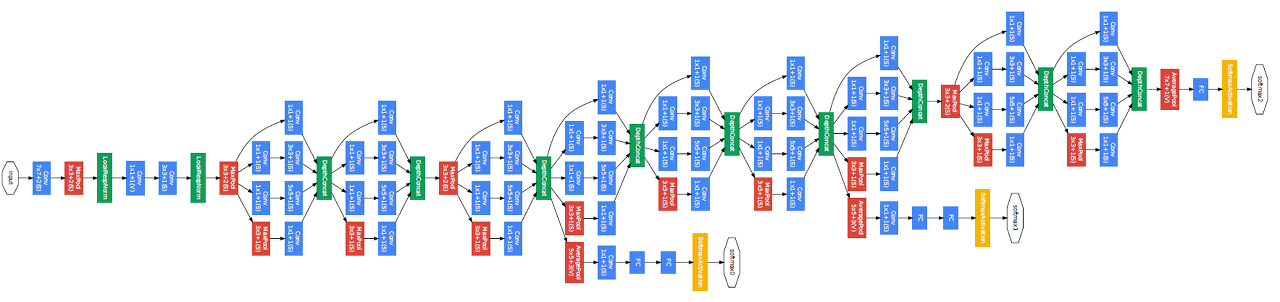

Inception 모듈 구현에 앞서 인셉션 모듈에서 반복적으로 사용될 Conv layer를 생성하기 위해 ConvBlock란 클래스로 구현

Conv layer 뒤에 batch normalization layer와 relu가 뒤따르는 구조

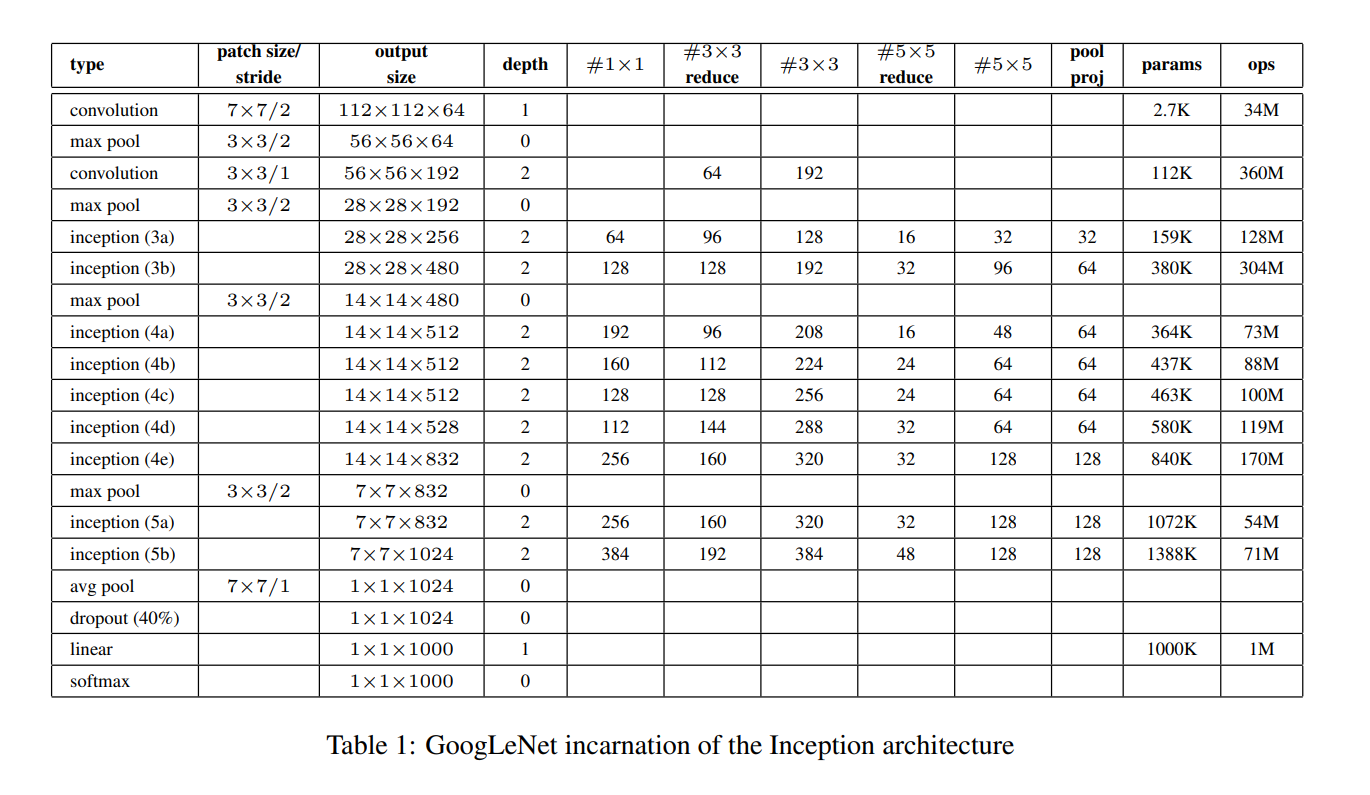

In [3]:
import torch
import torch.nn as nn
from torch import Tensor

class ConvBlock(nn.Module):
    def __init__(self, in_channels, out_channels, **kwargs) -> None:
        super(ConvBlock, self).__init__()
        self.conv = nn.Conv2d(in_channels, out_channels, **kwargs)
        self.batchnorm = nn.BatchNorm2d(out_channels)
        self.relu = nn.ReLU()

    def forward(self, x: Tensor) -> Tensor:
        x = self.conv(x)
        x = self.batchnorm(x)
        x = self.relu(x)
        return x

ConvBlock 클래스를 활용해 Imception modeule을 구현하기 위한 Inception 클래스 구현

In [4]:
class Inception(nn.Module):
    def __init__(self, in_channels, n1x1, n3x3_reduce, n3x3, n5x5_reduce, n5x5, pool_proj) -> None:
        super(Inception, self).__init__()
        self.branch1 = ConvBlock(in_channels, n1x1, kernel_size=1, stride=1, padding=0)

        self.branch2 = nn.Sequential(
            ConvBlock(in_channels, n3x3_reduce, kernel_size=1, stride=1, padding=0),
            ConvBlock(n3x3_reduce, n3x3, kernel_size=3, stride=1, padding=1))
        
        self.branch3 = nn.Sequential(
            ConvBlock(in_channels, n5x5_reduce, kernel_size=1, stride=1, padding=0),
            ConvBlock(n5x5_reduce, n5x5, kernel_size=5, stride=1, padding=2))

        self.branch4 = nn.Sequential(
            nn.MaxPool2d(kernel_size=3, stride=1, padding=1),
            ConvBlock(in_channels, pool_proj, kernel_size=1, stride=1, padding=0))
        
    def forward(self, x: Tensor) -> Tensor:
        x1 = self.branch1(x)
        x2 = self.branch2(x)
        x3 = self.branch3(x)
        x4 = self.branch4(x)
        return torch.cat([x1, x2, x3, x4], dim=1)

Inception 클래스 내부를 확인하면 4개의 branch 변수를 만든다. 이 4개의 branch 변수는 각각 아래 Inception module에서 네 갈래로 분기되는 것을 구현
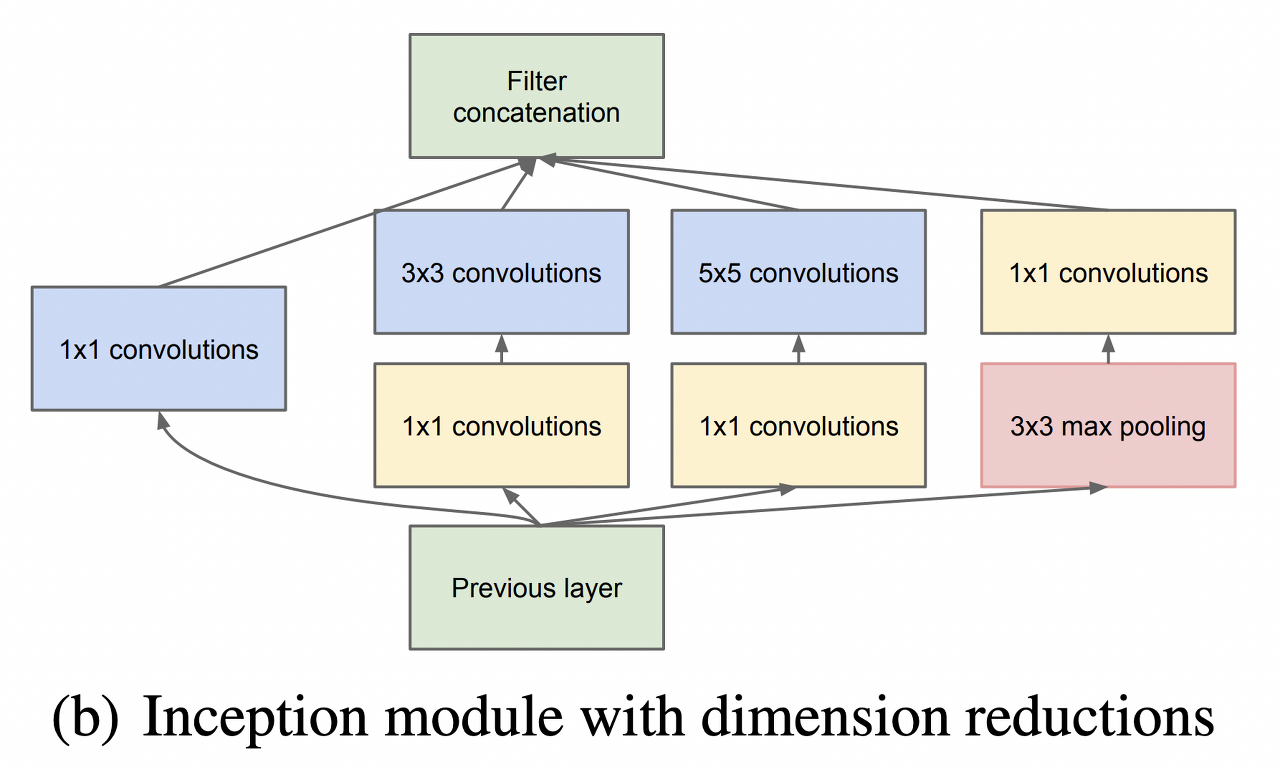
Inception 모듈에 들어갈 인자는 다음과 같다.
- 1x1 convolution의 경우 kernel_size=1, stride= 1, padding=0
- 3x3 convolution의 경우 kernel_size=3, stride= 1, padding=1
- 5x5 convolution의 경우 kernel_size=5, stride= 1, pading=2
- max-pooling의 경우 kernel_size=3, stride=1, padding=1

Auxiliary Classifier를 구현하기 위해 아래와 같이 InceptionAux라는 클래스로 구현함.

1 x 1 convolution의 output channel의 개수는 논문에 기술된 대로 128을 적용해줬으며 dropout rate 또한 논문에 기술된 대로 0.7을 적용

In [5]:
class InceptionAux(nn.Module):
    def __init__(self, in_channels, num_classes) -> None:
        super(InceptionAux, self).__init__()
        self.avgpool = nn.AvgPool2d(kernel_size=5, stride=3)
        self.conv = ConvBlock(in_channels, 128, kernel_size=1, stride=1, padding=0)
        self.fc1 = nn.Linear(2048, 1024)
        self.fc2 = nn.Linear(1024, num_classes)
        self.dropout = nn.Dropout(p=0.7)
        self.relu = nn.ReLU()

    def forward(self, x: Tensor) -> Tensor:
        x = self.avgpool(x)
        x = self.conv(x)
        x = x.view(x.size()[0], -1)
        x = self.fc1(x)
        x = self.relu(x)
        x = self.dropout(x)
        x = self.fc2(x)
        return x

ConvBlock, Inception, InceptionAux를 활용하여 GoogLeNet 구현

In [ ]:
from typing import Optional

class GoogLeNet(nn.Module):
    def __init__(self, aux_logits=True, num_classes=1000) -> None:
        super(GoogLeNet, self).__init__()
        assert aux_logits == True or aux_logits == False
        self.aux_logits = aux_logits

        self.conv1 = ConvBlock(in_channels=3, out_channels=64, kernel_size=7, stride=2, padding=3)
        self.maxpool1 = nn.MaxPool2d(kernel_size=3, stride=2, padding=1, ceil_mode=True)
        self.conv2 = ConvBlock(in_channels=64, out_channels=64, kernel_size=1, stride=1, padding=0)
        self.conv3 = ConvBlock(in_channels=64, out_channels=192, kernel_size=3, stride=1, padding=1)
        self.maxpool2 = nn.MaxPool2d(kernel_size=3, stride=2, ceil_mode=True)

        self.a3 = Inception(192, 64, 96, 128, 16, 32, 32)
        self.b3 = Inception(256, 128, 128, 192, 32, 96, 64)
        self.maxpool3 = nn.MaxPool2d(kernel_size=3, stride=2, padding=1, ceil_mode=True)
        self.a4 = Inception(480, 192, 96, 208, 16, 48, 64)
        self.b4 = Inception(512, 160, 112, 224, 24, 64, 64)
        self.c4 = Inception(512, 128, 128, 256, 24, 64, 64)
        self.d4 = Inception(512, 112, 144, 288, 32, 64, 64)
        self.e4 = Inception(528, 256, 160, 320, 32, 128, 128)
        self.maxpool4 = nn.MaxPool2d(kernel_size=3, stride=2, padding=1)
        self.a5 = Inception(832, 256, 160, 320, 32, 128, 128)
        self.b5 = Inception(832, 384, 192, 384, 48, 128, 128)
        self.avgpool = nn.AvgPool2d(kernel_size=8, stride=1)
        self.dropout = nn.Dropout(p=0.4)
        self.linear = nn.Linear(1024, num_classes)

        if self.aux_logits:
            self.aux1 = InceptionAux(512, num_classes)
            self.aux2 = InceptionAux(528, num_classes)
        else:
            self.aux1 = None
            self.aux2 = None

    def transform_input(self, x: Tensor) -> Tensor:
        x_R = torch.unsqueeze(x[:, 0], 1) * (0.229 / 0.5) + (0.485 - 0.5) / 0.5
        x_G = torch.unsqueeze(x[:, 1], 1) * (0.224 / 0.5) + (0.456 - 0.5) / 0.5
        x_B = torch.unsqueeze(x[:, 2], 1) * (0.225 / 0.5) + (0.406 - 0.5) / 0.5
        x = torch.cat([x_R, x_G, x_B], 1)
        return x
        
    def forward(self, x: Tensor) -> Tensor:
        x = self.transform_input(x)

        x = self.conv1(x)
        x = self.maxpool1(x)
        x = self.conv2(x)
        x = self.conv3(x)
        x = self.maxpool2(x)
        x = self.a3(x)
        x = self.b3(x)
        x = self.maxpool3(x)
        x = self.a4(x)
        aux1: Optional[Tensor] = None
        if self.aux_logits and self.training:
            aux1 = self.aux1(x)

        x = self.b4(x)
        x = self.c4(x)
        x = self.d4(x)
        aux2: Optional[Tensor] = None
        if self.aux_logits and self.training:
            aux2 = self.aux2(x)

        x = self.e4(x)
        x = self.maxpool4(x)
        x = self.a5(x)
        x = self.b5(x)
        x = self.avgpool(x)
        x = x.view(x.shape[0], -1) # x = x.reshape(x.shape[0], -1)
        x = self.linear(x)
        x = self.dropout(x)

        if self.aux_logits and self.training:
            return aux1, aux2
        else:
            return x